In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, MaxPooling2D, MaxPool2D, concatenate, Concatenate, Dropout, BatchNormalization
# from keras.optimizers import Adam
from keras import Model

DATA PREPROCESSING

In [2]:
training_images_dir = "dataset/training/images/"
training_masks_dir = "dataset/training/masks/"

test_images_dir = "dataset/test/images/"
test_masks_dir = "dataset/test/masks/"

training_images_list = []
training_masks_list = []

test_images_list = []
test_masks_list = []

SIZE = 128

In [3]:
training_images = os.listdir(training_images_dir)
training_masks = os.listdir(training_masks_dir)

print("Fetching training images and resizing...")
for i, image_name in tqdm(enumerate(training_images), total=len(training_images)):
    if (image_name.split('.')[1] == 'tif'):
        img = cv2.imread(training_images_dir + image_name, 0)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
        training_images_list.append(np.array(img))
        
print('DONE!')

print("Fetching masks and resizing...")
for i, mask_name in tqdm(enumerate(training_masks), total=len(training_masks)):
    if (mask_name.split('.')[1] == 'tif'):
        img = cv2.imread(training_masks_dir + mask_name, 0)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
        training_masks_list.append(np.array(img))

print('DONE!')

Fetching training images and resizing...


100%|██████████| 165/165 [00:01<00:00, 111.38it/s]


DONE!
Fetching masks and resizing...


100%|██████████| 165/165 [00:01<00:00, 124.17it/s]

DONE!


In [4]:
test_images = os.listdir(test_images_dir)
test_masks = os.listdir(test_masks_dir)

print("Fetching testing images and resizing...")
for i, image_name in tqdm(enumerate(test_images), total=len(test_images)):
    if (image_name.split('.')[1] == 'tif'):
        img = cv2.imread(test_images_dir + image_name, 0)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
        test_images_list.append(np.array(img))
        
print('DONE!')

print("Fetching masks and resizing...")
for i, mask_name in tqdm(enumerate(test_masks), total=len(test_masks)):
    if (mask_name.split('.')[1] == 'tif'):
        img = cv2.imread(test_masks_dir + mask_name, 0)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
        test_masks_list.append(np.array(img))

print('DONE!')

Fetching testing images and resizing...


100%|██████████| 165/165 [00:01<00:00, 113.00it/s]


DONE!
Fetching masks and resizing...


100%|██████████| 165/165 [00:01<00:00, 126.16it/s]

DONE!


In [5]:
# Normalize all images to the range [0, 1]
training_images_dataset = cv2.normalize(np.array(training_images_list), None, 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
training_images_dataset = np.expand_dims(training_images_dataset, 3)
training_masks_dataset = np.expand_dims(np.array(training_masks_list), 3) / 255.0

# X_train = training_images_dataset
# y_train = training_masks_dataset

# # Normalize all masks to the range [0, 1]
# test_images_dataset = cv2.normalize(np.array(test_images_list), None, 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# test_images_dataset = np.expand_dims(test_images_dataset, 3)
# test_masks_dataset = np.expand_dims(np.array(test_masks_list), 3) / 255

# X_test = test_images_dataset
# y_test = test_masks_dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(training_images_dataset, training_masks_dataset, test_size=0.1, random_state=0)

In [7]:
def show_images(image1, image2, image1_title, image2_title):
    # plt.figure(figsize=(10,5))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(image1, cmap='gray')
    ax.set_axis_off()
    ax.set_title(image1_title)

    ax = plt.subplot(1, 2, 2)
    ax.imshow(image2, cmap='gray')
    ax.set_axis_off()
    ax.set_title(image2_title)

    plt.show()
    
def show_testing_images(image1, image2, image3, image1_title, image2_title, image3_title):
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image1, cmap='gray')
    ax.set_axis_off()
    if image1_title is not None:
        ax.set_title(image1_title)
        
    ax = plt.subplot(1, 3, 2)
    ax.imshow(image2, cmap='gray')
    ax.set_axis_off()
    if image2_title is not None:
        ax.set_title(image2_title)
        
    ax = plt.subplot(1, 3, 3)
    ax.imshow(image3, cmap='gray')
    ax.set_axis_off()
    if image3_title is not None:
        ax.set_title(image3_title)
        
    plt.show()    


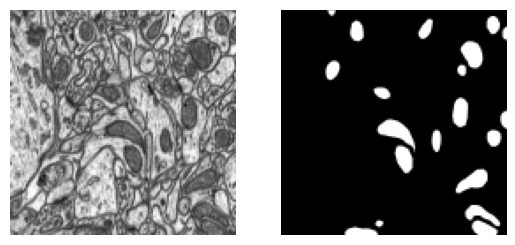

In [12]:
img_num = random.randint(0, len(X_train) - 1)
show_images(X_train[img_num], y_train[img_num], "","")

BUILD UNET MODEL

In [14]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(in_, num_filters):
    x = conv_block(in_, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(
        num_filters, (2, 2), strides=2, padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(
        1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model


In [13]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [14]:
IMG_HEIGHT =  training_images_dataset.shape[1]
IMG_WIDTH = training_images_dataset.shape[2]
IMG_CHANNELS = training_images_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# model = build_unet(input_shape)
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                           

In [16]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
    # tf.keras.callbacks.TensorBoard(log_dir='logs')
    # checkpointer
]

history = model.fit(X_train, y_train, batch_size=8, verbose=1,
                    epochs=25, validation_data=(X_test, y_test), shuffle=False)
# results = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=25, callbacks=callbacks)


Epoch 1/25
19/19 [==============================] - 2s 114ms/step - loss: 0.0333 - accuracy: 0.9675 - val_loss: 0.0262 - val_accuracy: 0.9712
Epoch 2/25
19/19 [==============================] - 2s 112ms/step - loss: 0.0327 - accuracy: 0.9678 - val_loss: 0.0279 - val_accuracy: 0.9709
Epoch 3/25
19/19 [==============================] - 2s 113ms/step - loss: 0.0315 - accuracy: 0.9682 - val_loss: 0.0242 - val_accuracy: 0.9717
Epoch 4/25
19/19 [==============================] - 2s 114ms/step - loss: 0.0302 - accuracy: 0.9685 - val_loss: 0.0250 - val_accuracy: 0.9715
Epoch 5/25
19/19 [==============================] - 2s 114ms/step - loss: 0.0296 - accuracy: 0.9687 - val_loss: 0.0242 - val_accuracy: 0.9718
Epoch 6/25
19/19 [==============================] - 2s 111ms/step - loss: 0.0288 - accuracy: 0.9689 - val_loss: 0.0243 - val_accuracy: 0.9718
Epoch 7/25
19/19 [==============================] - 2s 111ms/step - loss: 0.0274 - accuracy: 0.9693 - val_loss: 0.0224 - val_accuracy: 0.9721
Epoch 

1/1 [==============================] - 0s 92ms/step - loss: 0.0188 - accuracy: 0.9725
Accuracy =  97.25018739700317 %


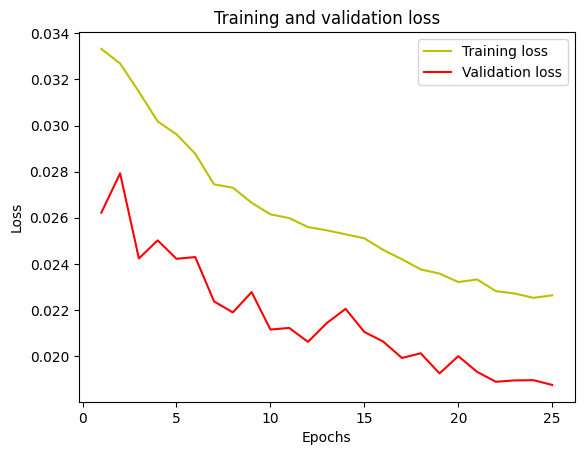

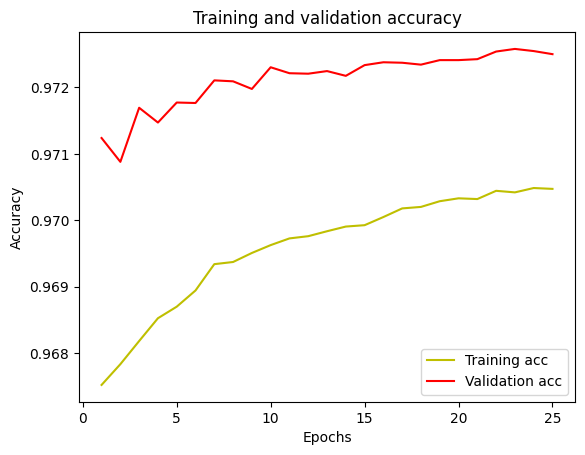

In [17]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

IOU

In [18]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

1/1 [==============================] - 0s 270ms/step
IoU score is:  0.7744522486633819


1/1 [==============================] - 0s 24ms/step


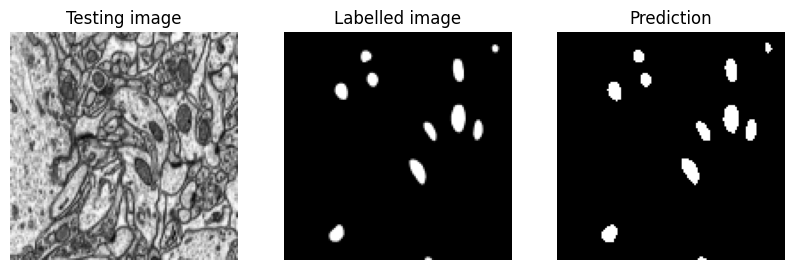

In [21]:
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number] # Fetch original testing image
ground_truth=y_test[test_img_number] # Fetch labeled testing image
test_img_norm=test_img[:,:,0][:,:,None] 
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (np.squeeze(model.predict(test_img_input), axis=(0, 3)) > 0.2).astype(np.uint8)

show_testing_images(np.squeeze(test_img), np.squeeze(ground_truth), prediction, "Testing image", "Labelled image", "Prediction")